In [1]:
# Code used to create the plots in section 4.7.2 and 4.7.3 in the paper:
# "Analysis and Comparison of Classification Metrics" 

# This script assumes you have cloned the psr-calibration repository
# and links the psrcal folder in the main directory in this repository
# (i.e., one level above this notebook)

import re
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
import torch

sys.path += ["../../", "../"]
from expected_cost import ec, utils
from data import get_llks_for_multi_classif_task, create_scores_for_expts
from psrcal.losses import LogLoss, ECE, ECEbin, Brier, CalLossBrier, CalLossLogLoss, plot_reliability_diagram


In [2]:
# Compute normalized metrics
adjusted_cost = True

sep1 = " "
sep2 = "|"
sep3 = ""

def print_header(metric_dict, score_dict):
    print(f"{'':>13s}  {sep2}", end='')
    for metric_name, metric in metric_dict.items():
        print(f" {metric_name:<22s} {sep2}", end='')
    print("")
    print(f"{'Score_type':<13s}  {sep2}", end='')
    for metric_name, metric in metric_dict.items():
        for rc in score_dict.keys():
            print(f"{sep1}  {rc}  ", end='')
        print(sep2, end='')
    print(sep3)

outdir = "outputs/psr_and_calibration_analysis"
utils.mkdir_p(outdir)

Generate a bunch of different posteriors for a C class problem (C can be changed to whatever you like). First, generate likelihoods with Gaussian class distributions and then compute:

* Datap: log-posteriors obtained from the llks applying the true data priors

* Mismp: log-posteriors obtained from the llks applying the mismatched data priors to simulate a system that was trained with the wrong priors

Two llk versions are used (cal, mc1): miscalibrated and calibrated ones, resulting in two versions of each of the above posteriors. Finally, another miscalibrated version of the posteriors (mc2) is created by scaling the log-posteriors directly.

For each of the 6 posteriors (Datap/Mismp-cal/mc1/mc2), two calibrated versions, using an affine transformation and temp scaling are also created.



In [3]:
num_targets = 2
score_dict, targets = create_scores_for_expts(num_targets)




**** Creating simulated data with Gaussian class distributions for 2 classes ****



Now, using the logposteriors computed with matched priors, compute a family of cost matrices varying the costs for the last row (in the log domain) and leaving the other one fixed at 1. For each of these matrices compute the cost for maximum-a-posterior decisions and the cost for Bayes decisions. 

In [5]:
print("Normalized expected cost (NEC) for cost matrix with c_ii = 0, c_ij = 1 for i!=j and i!=C, and c_ij = alpha, for i!=j and i=C, ")
print("using calibrated (cal) and misscalibrated (mc1) log posteriors computed with the data priors\n")

if num_targets == 2:
    print("Alpha \t NEC_MAP_mc1 \t NEC_Bayes_mc1 \t NEC_Bayes_cal \t NEC_Optimal")
else:
    print("Alpha \t NEC_MAP_mc1 \t NEC_Bayes_mc1 \t NEC_Bayes_cal")

# Maximum a posteriori decisions
map_decisions = np.argmax(score_dict['mc1']['Datap'], axis=-1)

for logalpha in np.arange(-4, 4, 0.5):
    alpha = np.exp(logalpha)

    # Create the cost matrix with alpha in the last row
    costm = 1 - np.eye(num_targets)
    costm[-1, 0:-1] = alpha
    cost = ec.CostMatrix(costm)

    # Compute the EC for MAP and Bayes decisions made with miscalibrated posteriors
    # and for Bayes decisions made with calibrated posteriors.
    ec_map = ec.average_cost(targets, map_decisions, cost, adjusted=adjusted_cost)
    ec_bayes, _ = ec.average_cost_for_bayes_decisions(targets, score_dict['mc1']['Datap'], cost, adjusted=adjusted_cost)
    ec_bayes_after_cal, _ = ec.average_cost_for_bayes_decisions(targets, score_dict['cal']['Datap'], cost, adjusted=adjusted_cost)

    if num_targets == 2:
        # For the binary case we can also compute the optimal NEC (normalized expected cost)
        # obtained by sweeping a threshold and choosing the one that minimizes the NEC
        ec_min = ec.average_cost_for_optimal_decisions(targets, score_dict['mc1']['Datap'], cost, adjusted=adjusted_cost)
        print(f"{alpha:6.3f} \t {ec_map:6.3f} \t {ec_bayes:6.3f} \t {ec_bayes_after_cal:6.3f} \t {ec_min:6.3f}")
    else:
        print(f"{alpha:6.3f} \t {ec_map:6.3f} \t {ec_bayes:6.3f} \t {ec_bayes_after_cal:6.3f}")


Normalized expected cost (NEC) for cost matrix with c_ii = 0, c_ij = 1 for i!=j and i!=C, and c_ij = alpha, for i!=j and i=C, 
using calibrated (cal) and misscalibrated (mc1) log posteriors computed with the data priors

Alpha 	 NEC_MAP_mc1 	 NEC_Bayes_mc1 	 NEC_Bayes_cal 	 NEC_Optimal
 0.018 	  0.973 	  1.000 	  0.913 	  0.901
 0.030 	  0.898 	  1.000 	  0.887 	  0.885
 0.050 	  0.853 	  0.999 	  0.846 	  0.843
 0.082 	  0.825 	  0.997 	  0.802 	  0.796
 0.135 	  0.808 	  0.990 	  0.740 	  0.739
 0.223 	  0.798 	  0.972 	  0.675 	  0.674
 0.368 	  0.792 	  0.942 	  0.613 	  0.611
 0.607 	  0.788 	  0.881 	  0.541 	  0.539
 1.000 	  0.786 	  0.786 	  0.467 	  0.464
 1.649 	  0.784 	  0.658 	  0.394 	  0.392
 2.718 	  0.784 	  0.518 	  0.326 	  0.325
 4.482 	  0.783 	  0.378 	  0.265 	  0.264
 7.389 	  0.783 	  0.260 	  0.210 	  0.210
12.182 	  1.059 	  0.238 	  0.223 	  0.222
20.086 	  1.746 	  0.283 	  0.283 	  0.281
33.115 	  2.878 	  0.350 	  0.346 	  0.345


In the table above:
* Columns 2 through 5 are the normalized expected cost (NEC) when decisions are made with different algorithms.
* The name of the column indicates how the decisions were made: MAP decisions, Bayes decisions on raw scores, Bayes decisions on calibrated scores, and when C=2, optimal decisions (ie, selecting the "cheating" best threshold for the test data).
* The difference between NEC_MAP_mc1 and NEC_Bayes_mc1 shows the suboptimality of MAP decisions when the costs are not equal.
* The difference between the NEC_Bayes_mc1 and the NEC_Bayes_cal shows how well or badly calibrated the system scores are. Larger differences indicate a more severe calibration problem at that specific operating point. 
* (Only for binary classification) The difference between NEC_Bayes_cal and NEC_Optimal indicates that either the calibration did not work perfectly for that operating point or that the optimal cost is, in fact, too optimistic since the threshold is selected on the evaluation data itself.




In [7]:
print("Average cost for cost matrix with c_ii=0, c_ij=1 for i!=j, and with a last column for an abstention decision with cost alpha, ")
print("using calibrated (cal) and misscalibrated (mc1) log posteriors computed with the data priors\n")
print("        |   mc1    |               mc1             |            cal")
print("Alpha   |   MAP    |  EC_Bayes  NEC_Bayes   %Abs   |  EC_Bayes   NEC_Bayes   %Abs")

for alpha in [0.01, 0.1, 0.2, 0.4, 0.6, 1.0]:

    # Create a cost matrix with an abstention decision
    cost = ec.CostMatrix.zero_one_costs(num_targets, abstention_cost=alpha)

    # Compute the EC for MAP and Bayes decisions made with miscalibrated posteriors
    # and for Bayes decisions made with calibrated posteriors.
    ec_map = ec.average_cost(targets, map_decisions, cost, adjusted=adjusted_cost)
    ec_bayes, decisions, = ec.average_cost_for_bayes_decisions(targets, score_dict['mc1']['Datap'], cost, adjusted=adjusted_cost)
    ec_bayes_after_cal, decisions_after_cal = ec.average_cost_for_bayes_decisions(targets, score_dict['cal']['Datap'], cost, adjusted=adjusted_cost)

    # Non-normalized ECs for comparison
    ec_bayes_nonorm, _ = ec.average_cost_for_bayes_decisions(targets, score_dict['mc1']['Datap'], cost, adjusted=False)
    ec_bayes_after_cal_nonorm, _ = ec.average_cost_for_bayes_decisions(targets, score_dict['cal']['Datap'], cost, adjusted=False)

    # Percentage of samples for which the abstention decision is made
    perc_abs = np.sum(decisions == num_targets) / len(decisions) * 100
    perc_abs_after_cal = np.sum(decisions_after_cal == num_targets) / len(decisions) * 100

    print(f"{alpha:6.3f}  |  {ec_map:6.3f}  |   {ec_bayes_nonorm:6.3f}    {ec_bayes:6.3f}   {perc_abs:6.1f}   |   {ec_bayes_after_cal_nonorm:6.3f}    {ec_bayes_after_cal:6.3f}    {perc_abs_after_cal:6.1f}")


Average cost for cost matrix with c_ii=0, c_ij=1 for i!=j, and with a last column for an abstention decision with cost alpha, 
using calibrated (cal) and misscalibrated (mc1) log posteriors computed with the data priors

        |   mc1    |               mc1             |            cal
Alpha   |   MAP    |  EC_Bayes  NEC_Bayes   %Abs   |  EC_Bayes   NEC_Bayes   %Abs
 0.010  |   7.857  |    0.006     0.638     61.5   |    0.005     0.534      41.1
 0.100  |   0.786  |    0.030     0.299     12.3   |    0.025     0.249      14.1
 0.200  |   0.786  |    0.052     0.521      6.7   |    0.035     0.355       8.2
 0.400  |   0.786  |    0.076     0.756      2.0   |    0.046     0.456       2.3
 0.600  |   0.786  |    0.079     0.786      0.0   |    0.047     0.467       0.0
 1.000  |   0.786  |    0.079     0.786      0.0   |    0.047     0.467       0.0


In the table above:
* The lower the cost of abstention, the more samples get this label and the worse the MAP decisions are (since they do not take advantage of the abstention option). 
* If the cost of abstention is too high, the system never chooses to abstain.
* The difference between the EC_Bayes (or NEC_Bayes) columns for mc1 and for cal posteriors show the extent of the misscalibration in the mc1 posteriors.
* EC_Bayes decreases as alpha decreases, since the system chooses to abstain when it is cheaper than choosing one of the two classes.
* On the other hand NEC_Bayes does not decrease monotonically with alpha because the normalization factor is affected by alpha (when alpha is very small, it is very hard to beat the naïve system that always chooses to abstain).
* Note that, even for the binary case, when the cost function has an abstention decision, optimal decisions cannot be made by sweeping a threshold as for the square cost function above because there are three possible decisions


---

Finally, analyze the issue of mismatched priors and calibration with various metrics.

To this end, we evaluate a couple of expected costs (using Bayes decisions) and other metrics for each of the posteriors generated above. In all cases we take the target priors to be the ones in the test data. 

In [9]:
# Evaluate with two different ECs, cross-entropy (expected log loss) and Brier score
cost_01 = ec.CostMatrix.zero_one_costs(num_targets)
cost_ab1 = ec.CostMatrix.zero_one_costs(num_targets, abstention_cost=0.1)
metric_dict = {
    'cost_01': cost_01, 
    'cost_01_abs=0.1': cost_ab1, 
    'cross-entropy': LogLoss, 
    'brier-score': Brier
    }


In [10]:
print_header(metric_dict, score_dict)

for score_name in np.sort(list(score_dict['mc1'].keys())):
    if 'llks' in score_name or 'caltt' in score_name: continue
    print(f"{score_name:<13s}  {sep2}", end='')

    for metric_name, metric in metric_dict.items():
        for rc in score_dict.keys():
            scores = score_dict[rc][score_name]
            
            if 'cost' in metric_name:
                metric_value, _ = ec.average_cost_for_bayes_decisions(targets, scores, metric, adjusted=adjusted_cost, silent=True)
            else:
                # For cross-entropy and Brier, use the psrcal repository, which
                # works with torch tensors
                metric_value = metric(torch.tensor(scores), torch.tensor(targets))

            print(f"{sep1} {metric_value:4.2f}  ", end='')
        print(sep2, end='')
    print(sep3)

               | cost_01                | cost_01_abs=0.1        | cross-entropy          | brier-score            |
Score_type     |   cal     mc1     mc2  |   cal     mc1     mc2  |   cal     mc1     mc2  |   cal     mc1     mc2  |
Datap          |  0.47    0.79    0.47  |  0.25    0.30    0.38  |  0.38    0.53    1.07  |  0.39    0.60    0.47  |
Datap-affcal   |  0.47    0.47    0.47  |  0.25    0.25    0.25  |  0.38    0.38    0.38  |  0.39    0.39    0.39  |
Datap-hiscal   |  0.47    0.49    0.46  |  0.25    0.25    0.35  |  0.40     inf    0.50  |  0.39    0.40    0.44  |
Datap-temcal   |  0.47    0.79    0.47  |  0.25    0.28    0.25  |  0.38    0.52    0.38  |  0.39    0.58    0.39  |
Mismp          |  2.98    4.59    2.98  |  1.39    1.25    2.55  |  2.13    2.47    7.84  |  2.38    3.18    3.04  |
Mismp-affcal   |  0.47    0.47    0.47  |  0.25    0.25    0.25  |  0.38    0.38    0.38  |  0.39    0.39    0.39  |
Mismp-hiscal   |  0.76    0.48    1.00  |  0.28    0.28    0.36 

In the table above:
* For the Datap row, the difference between the cal and the mc1 or mc2 columns show the effect of the two types of miscalibration.
* The difference between the Datap and Mismp results in the same column show the effect of using mismatched priors when computing the log-posteriors, which is another type of miscalibration.
* The affc and tempc rows show the effect of calibration using an affine or temp-scale calibration transformation (trained with cross-validation on the test scores). We can see that temp-scaling does not solve calibration issues in all cases. For example, it cannot fix posteriors computed with mismatched priors. On the other hand, the affine calibration transformation completely fixes calibration for these examples (which are, granted, simulated so that an affine transformation is indeed optimal for calibration).
* Note that the Datap-cal posteriors correspond to perfectly calibrated posteriors, both because the llks were perfectly calibrated and because we used matched priors to compute the posteriors. Hence, they are they absolute best you can do for this dataset.


In [11]:
metric_dict = {'Cal-loss-cross-entropy': CalLossLogLoss, 
               'Cal-loss-brier-score': CalLossBrier, 
               'ECE': ECE}

print_header(metric_dict, score_dict)

for score_name in np.sort(list(score_dict['mc1'].keys())):

    if 'llks' in score_name or 'caltt' in score_name: continue
    print(f"{score_name:<13s}  {sep2}", end='')

    for metric_name, metric in metric_dict.items():
        for rc in score_dict.keys():
            scores = score_dict[rc][score_name]
            
            if metric_name == "ECE":
                metric_value = metric(torch.tensor(scores), torch.tensor(targets))
            else:
                score_name_before_cal = re.sub("-...cal", "", score_name)
                cal_scores = score_dict[rc][f"{score_name_before_cal}-affcal"]
                metric_value = metric(torch.tensor(scores), torch.tensor(cal_scores), torch.tensor(targets))

            print(f"{sep1} {metric_value:4.0f}  ", end='')
        print(sep2, end='')
    print(sep3)


               | Cal-loss-cross-entropy | Cal-loss-brier-score   | ECE                    |
Score_type     |   cal     mc1     mc2  |   cal     mc1     mc2  |   cal     mc1     mc2  |
Datap          |    -0      29      65  |    -0      35      16  |     0       4       4  |
Datap-affcal   |     0       0       0  |     0       0       0  |     0       0       0  |
Datap-hiscal   |     6     nan      24  |     1       3      11  |     0       0       0  |
Datap-temcal   |    -0      28      -0  |    -0      33      -0  |     0       4       0  |
Mismp          |    82      85      95  |    84      88      87  |    14      19      26  |
Mismp-affcal   |     0       0       0  |     0       0       0  |     0       0       0  |
Mismp-hiscal   |    21     nan      43  |    28       9      51  |     0       0       0  |
Mismp-temcal   |    78      82      78  |    82      85      82  |     1       6       1  |


In the table above:
* The calibration loss computed with cross-entropy and with Brier score are very similar for every system.
* The ECE, on the other hand, vastly underestimated the calibration problem in some cases. In particular, when the priors are mismatched but the llks are well calibrated (the Mismp-cal case), the ECE is very low, but the calibration is very bad, as we can tell from the value of the expected PSRs.


Multiclass ECE 3.878136487766809
Binary ECE 3.8868173516218794


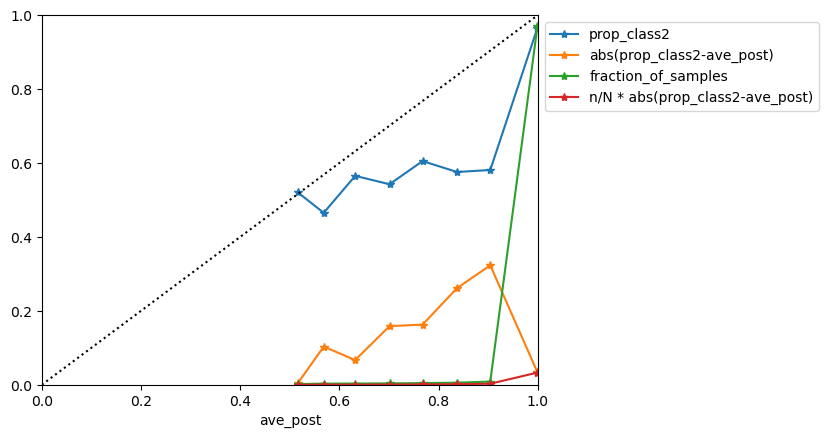

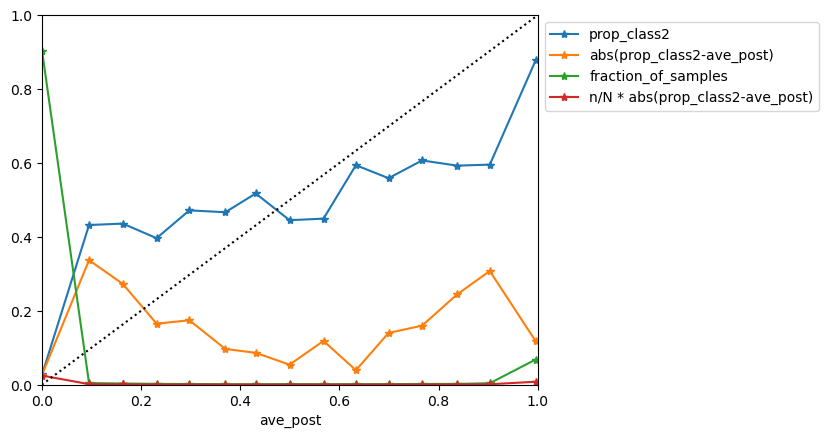

In [12]:
# Example on how to plot a version of the (multi-class) reliability diagram 
# (with lines instead of bars to show the actual place where the average 
# confidences land in each bin) which includes the values used to compute 
# the multi-class ECE.

# For the binary case, also include the corresponding plot for the binary
# reliability diagram and ECE (ie, without mapping the posteriors to confidences
# and the problem to one of deciding whether the system made a correct prediction)

rc = 'mc2'
score_name = 'Datap'
scores = score_dict[rc][score_name]

metric_value, ys, xs, counts = ECE(torch.tensor(scores), torch.tensor(targets), return_values=True)
plot_reliability_diagram(ys, xs, counts, f"{outdir}/reliability_diagram_{rc}_{score_name}.pdf")
print(f"Multiclass ECE {metric_value}")

if num_targets == 2:
    metric_value, ys, xs, counts = ECEbin(torch.tensor(scores), torch.tensor(targets), return_values=True)
    plot_reliability_diagram(ys, xs, counts, f"{outdir}/reliability_diagram_{rc}_{score_name}.pdf")
    print(f"Binary ECE {metric_value}")
